TFRecord 是 TensorFlow 中的数据集中存储格式。

将数据集整理成 TFRecord 格式后，TensorFlow 就可以高效地读取和处理这些数据集，从而更高效地进行大规模的模型训练。

# TFRecord格式数据文件处理过程
将形式各样的数据集整理为 TFRecord 格式，可以对数据集中的每个元素进行以下步骤：

1）读取该数据元素到内存；

2）将该元素转换为 tf.train.Example 对象（每一个 tf.train.Example 由若干个 tf.train.Feature 的字典组成，因此需要先建立 Feature 的字典）；

3）将该 tf.train.Example 对象序列化为字符串，并通过一个预先定义的 tf.io.TFRecordWriter 写入 TFRecord 文件。

读取 TFRecord 数据可按照以下步骤：

1）通过 tf.data.TFRecordDataset 读入原始的 TFRecord 文件（此时文件中的 tf.train.Example 对象尚未被反序列化），获得一个 tf.data.Dataset数据集对象；

2）通过 Dataset.map 方法，对该数据集对象中的每一个序列化的 tf.train.Example 字符串执行 tf.io.parse_single_example 函数，从而实现反序列化。

# 读取数据集的图片文件名列表及标签

In [32]:
def read_image_filenames(data_dir) :
    cat_dir = data_dir + "cat/"
    dog_dir = data_dir + "dog/"
    
    cat_filenames = [cat_dir + fn for fn in os.listdir(cat_dir)]
    dog_filenames = [dog_dir + fn for fn in os.listdir(dog_dir)]
    filenames = cat_filenames + dog_filenames
    
    # 将cat类的标签设为0， dog类的标签设为1
    labels = [0]* len(cat_filenames) + [1] *len(dog_filenames)
    
    return filenames,labels


# 定义生成TFRecord格式数据文件函数

In [33]:
def write_TFRecord_file(filenames,labels,tfrecord_file):
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for filename,label in zip(filenames,labels) :
            # 读取数据集图片到内存，image 为一个 Byte类型的字符串
            image = open(filename,"rb").read()
            # 建立tf.train.Feature字典
            feature = {
                    # 图片是一个Bytes对象
                    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                    # 标签是一个Int对象
                    'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
                    }
            # 通过feature字典建立Example
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            # 将Example序列化并写入TFRecord 文件
            writer.write(example.SerializeToString())


# TFRecord格式
tf.train.Feature 支持三种数据格式：

tf.train.BytesList ：字符串或原始 Byte 文件（如图片），通过 bytes_list 参数传入一个由字符串数组初始化的 tf.train.BytesList 对象；

tf.train.FloatList ：浮点数，通过 float_list 参数传入一个由浮点数数组初始化的 tf.train.FloatList 对象；

tf.train.Int64List ：整数，通过 int64_list 参数传入一个由整数数组初始化的 tf.train.Int64List 对象。

如果只希望保存一个元素而非数组，传入一个只有一个元素的数组即可

## 生成TFRecord格式数据文件

In [42]:
import os
import tensorflow as tfrecord_file

train_data_dir = './data_small/train/'  # 数据集路径
tfrecord_file = train_data_dir + 'train.tfrecords'  # 生成的tfrecord路径 

if not os.path.isfile(tfrecord_file): # 判断train.tfrecord是否存在
    train_filenames,train_labels = read_image_filenames(train_data_dir)
    write_TFRecord_file(train_filenames,train_labels,tfrecord_file)
    print('write TFRecord file:',tfrecord_file)
else:
    print(tfrecord_file,'already exists.')


write TFRecord file: ./data_small/train/train.tfrecords


## 定义TFRecord数据文件解码函数

In [43]:
# 定义Feature结构，告诉解码器每个Feature的类型是什么，要与生成的TFrecord的类型一致
feature_description = {
                        "image":tf.io.FixedLenFeature([],tf.string),
                        "label":tf.io.FixedLenFeature([],tf.int64)
                      }

# 将TFRecord 文件中的每一个序列化的 tf.train.Example 解码
def parse_example(example_string):
    feature_dict = tf.io.parse_single_example(example_string,feature_description)
    feature_dict['image'] = tf.io.decode_jpeg(feature_dict['image']) # 解码JPEG图片
    feature_dict['image'] = tf.image.resize(feature_dict['image'],[224,224])/ 255.0  # 改变图片尺寸并进行归一化
    return feature_dict['image'],feature_dict['label']



# 定义读取TFRecord文件，解码并生成Dataset数据集的函数

In [44]:
def read_TFRecond_file(tfrecord_file):
    # 读取TFRecord 文件
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    # 解码
    dataset = raw_dataset.map(parse_example)
    
    return dataset


# 读取TFRecord文件，解码并生成Dataset数据集

In [45]:
# Dataset的数据缓冲器大小，和数据集大小及规律有关
buffer_size = 20000
# Dataset的数据批次大小，每批次多少个样本数
batch_size = 8


In [46]:
dataset_train = read_TFRecond_file(tfrecord_file)  # 解码
dataset_train = dataset_train.shuffle(buffer_size)  # 打乱数据
dataset_train = dataset_train.batch(batch_size)  # 分批次进行读取

# 查看第一批元素

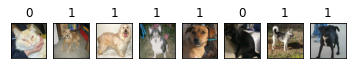

In [47]:
import matplotlib.pyplot as plt

sub_dataset = dataset_train.take(1)

for images,labels in sub_dataset:
    fig,axs = plt.subplots(1, batch_size)
    for i in range(batch_size):
        axs[i].set_title(labels.numpy()[i])
        axs[i].imshow(images.numpy()[i])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    plt.show()

# 模型训练

In [48]:
def vgg16_mode1(input_shape=(224,224,3)):
    vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, # 选择不包含顶层
                                              weights='imagenet',
                                              input_shape=input_shape)
    
    for layer in vgg16.layers:
        layer.trainable = False # 设置VGG-16预训练模型不可训练
        
    last = vgg16.output
    
    # 加入剩下未经训练的全连接层
    x = tf.keras.layers.Flatten()(last)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(2,activation='softmax')(x)
    
    # 建立新的模型
    model = tf.keras.models.Model(inputs=vgg16.input,outputs=x)
    model.summary()
    return model

In [49]:
# 新建模型
model = vgg16_mode1() # 模型设置
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [50]:
training_epochs = 3
model.fit(dataset_train,epochs=training_epochs,verbose=1)


Epoch 1/3
24/24 [==============================] - 7s 292ms/step - loss: 1.7397 - accuracy: 0.4531
Epoch 2/3
24/24 [==============================] - 7s 312ms/step - loss: 0.7268 - accuracy: 0.6562
Epoch 3/3
24/24 [==============================] - 12s 486ms/step - loss: 0.5253 - accuracy: 0.7500


# 将模型结构和模型权重参数分开存储

In [52]:
# 模型结构存储在.yaml文件中
yaml_string = model.to_yaml()
with open('./models/cat_dog.yaml','w') as model_file:
    model_file.write(yaml_string)
    # 模型权重参数存储在.h5文件中
    model.save_weights('./models/cat_dog.h5')

# 加载模型

In [53]:
# 恢复模型的结构
with open('./models/cat_dog.yaml') as yamlfile:
    loaded_model_yaml = yamlfile.read()

model = tf.keras.models.model_from_yaml(loaded_model_yaml) # 导入模型的权重参数
model.load_weights('./models/cat_dog.h5')

# 定义预测函数

In [55]:
from tensorflow. keras.preprocessing import image

# start代表从第几张开始读取，finish表示读到第几张为止
def read_image_files(path,start,finish,image_size=(224,224) ):
    test_files = os.listdir(path)
    test_images = []
    
    # 读取测试图片并进行预处理
    for fn in test_files[start:finish]:
        img_filename = path + fn
        img = image.load_img(img_filename,target_size=image_size)
        img_array = image.img_to_array(img)
        test_images.append(img_array)
        
    test_data = np.array(test_images)
    test_data /= 255.0
    
    print("You choose the image %d to image %d"%(start, finish))
    print("The test_data's shape is",end="")
    print(test_data.shape)
          
    return test_data


# 定义预测函数

In [63]:
def test_image_predict(path,start,finish,image_size=(224, 224)):
    # 读取测试图片并预处理
    test_data = read_image_files(path,start,finish,image_size) 
    
    # 执行预测
    preds = model.predict(test_data) 
    
    # 显示图片及预测结果
    for i in range (0,finish-start) :
        if np.argmax(preds[i]) == 0:
            label = "cat " + str(preds[i][0])
        else:
            label = "dog " + str(preds[i][1])
        plt.title(label)
        plt.imshow(test_data[i])
        plt.axis("off")
        plt.show()

# 执行预测

You choose the image 0 to image 5
The test_data's shape is(5, 224, 224, 3)


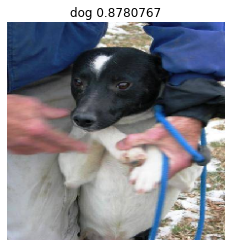

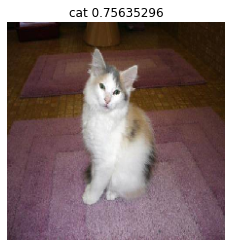

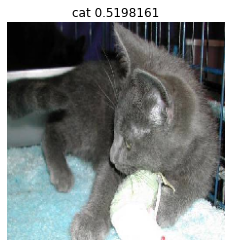

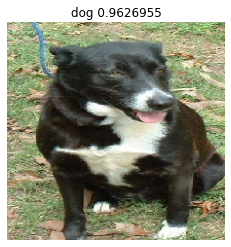

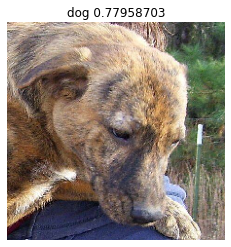

In [65]:
# 从test目录下读取训练数据
test_data_dir = "./data_samll/test/"
test_image_predict(test_data_dir,0,5)